In [75]:
import re
import random
import pandas as pd
import hashlib

In [76]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.5) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [77]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Python,78.662784,1.673676,10.062248,47
Powershell,477.710705,95.542141,245.243554,5
Todd Ideas,864.075679,57.605045,147.291183,15
PEP 8,1359.154556,169.894320,576.297499,8
SharePoint,1592.122402,132.676867,573.742627,12
Audit Report Tracker (Sharepoint List),1702.919316,130.993794,356.717551,13
Debugging in VS Code,1843.251216,92.162561,249.674454,20
Azure Functions + Visual Studio,1885.851802,134.703700,479.333438,14
Terraform,1888.796932,75.551877,248.698527,25
IW Migration,2038.245171,145.588941,452.886115,14


# Histogram

83830.83


<Axes: >

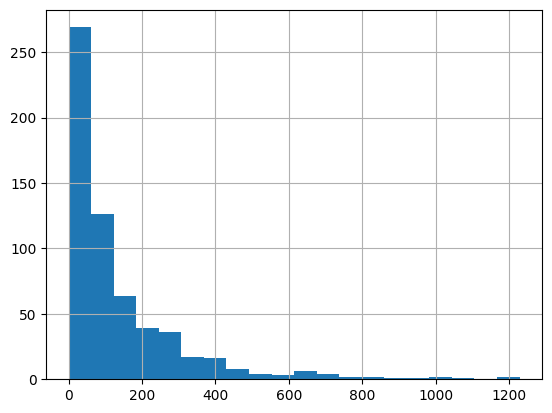

In [78]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [79]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [80]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [81]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [82]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [83]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [84]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [85]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [86]:
# n=10
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [87]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)



Cards found: 603


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
0,OData,IsSideEffecting Annotation (Org.OData.Core.V1....,d8914b66a46000e7d49d28751ef0ce4d,-995.161792,-348.315952,995.161792,5224.739274,0.525665,0,0
1,OData,"Metadata in OData describes the structure, dat...",6481d267891f44f7021eb148e72d7a2d,-470.269639,-348.315952,995.161792,5224.739274,0.525665,3,0
2,OData,Annotations provide additional metadata about ...,e10bfb62a2d41b4902e31c6dfa97b22a,-358.244774,-348.315952,995.161792,5224.739274,0.525665,6,0
3,OData,OData-defined system query options are optiona...,92d41ab5b340318de6b606ed3f94fda4,-176.488775,-348.315952,995.161792,5224.739274,0.525665,9,0
4,OData,OData services SHOULD NOT require any query op...,7b3849723952f8c81c62d569b4505b3e,-132.657934,-348.315952,995.161792,5224.739274,0.525665,12,0
5,Home Network Project,Front: What is TLS Termination and why is it u...,5297051eea9892af904815d3794faf15,-1195.253857,-285.065006,1195.253857,5416.235116,0.122978,0,0
6,Home Network Project,Front: What is Bandwidth and how does it diffe...,8d6d825a0008723089184f0a0131e2d6,-457.197498,-285.065006,1195.253857,5416.235116,0.122978,3,0
7,Home Network Project,Front: What is Rate Limiting and how does it h...,8178df4fba6be87bebbac33e10e32135,-304.762131,-285.065006,1195.253857,5416.235116,0.122978,6,0
8,Home Network Project,Front: What is Fail2Ban and how does it protec...,d7fc83e3380f6d95ec44141a17d86066,-193.441176,-285.065006,1195.253857,5416.235116,0.122978,9,0
9,Home Network Project,How do you install Docker on a Raspberry Pi?\n...,7900b83a7ba7844a4c599eafecb06af7,-91.776460,-285.065006,1195.253857,5416.235116,0.122978,12,0


## Age Max

In [88]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [89]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)




## Random

In [90]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [91]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
0,OData,IsSideEffecting Annotation (Org.OData.Core.V1....,d8914b66a46000e7d49d28751ef0ce4d,-995.161792,-348.315952,995.161792,5224.739274,0.525665,0,0
1,OData,"Metadata in OData describes the structure, dat...",6481d267891f44f7021eb148e72d7a2d,-470.269639,-348.315952,995.161792,5224.739274,0.525665,3,0
2,OData,Annotations provide additional metadata about ...,e10bfb62a2d41b4902e31c6dfa97b22a,-358.244774,-348.315952,995.161792,5224.739274,0.525665,6,0
3,OData,OData-defined system query options are optiona...,92d41ab5b340318de6b606ed3f94fda4,-176.488775,-348.315952,995.161792,5224.739274,0.525665,9,0
4,OData,OData services SHOULD NOT require any query op...,7b3849723952f8c81c62d569b4505b3e,-132.657934,-348.315952,995.161792,5224.739274,0.525665,12,0
5,Home Network Project,Front: What is TLS Termination and why is it u...,5297051eea9892af904815d3794faf15,-1195.253857,-285.065006,1195.253857,5416.235116,0.122978,0,0
6,Home Network Project,Front: What is Bandwidth and how does it diffe...,8d6d825a0008723089184f0a0131e2d6,-457.197498,-285.065006,1195.253857,5416.235116,0.122978,3,0
7,Home Network Project,Front: What is Rate Limiting and how does it h...,8178df4fba6be87bebbac33e10e32135,-304.762131,-285.065006,1195.253857,5416.235116,0.122978,6,0
8,Home Network Project,Front: What is Fail2Ban and how does it protec...,d7fc83e3380f6d95ec44141a17d86066,-193.441176,-285.065006,1195.253857,5416.235116,0.122978,9,0
9,Home Network Project,How do you install Docker on a Raspberry Pi?\n...,7900b83a7ba7844a4c599eafecb06af7,-91.776460,-285.065006,1195.253857,5416.235116,0.122978,12,0


In [92]:
existing_cards['age'].mean()

-139.0229331866465